In [1]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from data.load_dataset import load_dataset
from data.merge_dataset import merge_dataset
from data.feature_engineering import *
from model.inference import save_csv
from model.feature_select import select_features
from model.data_split import split_features_and_target
from model.model_train import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import os
import wandb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
match torch.cuda.is_available():
    case True: device = "cuda"
    case _: device = "cpu"

device

'cuda'

In [3]:
train_data, test_data, sample_submission, interest_data, subway_data, school_data, park_data = load_dataset()
# 기존 데이터에 새로운 feature들을 병합한 데이터프레임 불러오기
train_data, test_data = merge_dataset(train_data, test_data, interest_data, subway_data, school_data, park_data)

### 3. Data Preprocessing

# 위치 중복도 낮은 행 삭제
groups = train_data.groupby(["latitude", "longitude"])["index"].count()
conditioned_groups_index = groups[(groups >= 2) & (groups <= 5)].index # 이 범위를 파라미터로 조정하는걸로
small_groups = train_data[
    train_data["latitude"].isin(conditioned_groups_index.get_level_values(0)) &
    train_data["longitude"].isin(conditioned_groups_index.get_level_values(1))
]
train_data.drop(small_groups.index, axis=0, inplace=True)

# built_year > 2024 행 삭제
train_data = train_data[train_data["built_year"] < 2024]
train_data.reset_index(drop=True, inplace=True)

# log 변환
train_data, test_data = apply_log_transformation(train_data, test_data)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log1p
  result = func(self.values, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


In [4]:
selected_cols = [
    "log_area_m2",
    "built_year",
    "latitude",
    "longitude",
    "log_leader_distance",
    "log_subway_distance",
    "log_school_distance",
    "log_park_distance",
    "contract_year_month",
    # "contract_day",
    "num_of_subways_within_radius",
    "park",
    "region"
]
X_train, y_train = train_data[selected_cols], train_data["deposit"]
X_test = test_data[selected_cols]
log_y_train = train_data["log_deposit"]

# 1. 데이터 불러오기
X_tensor = torch.tensor(X_train.values, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32, device=device)

train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [5]:
# 2. 모델 정의
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(12, 4)
        self.fc2 = nn.Linear(4, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        # out = self.dense3(out)
        # out = self.relu(out)
        return out

# 3. 모델 인스턴스 생성
model = SimpleModel()
model.to(device)

# 가중치 초기화
for layer in model.children():
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)

# 4. 손실 함수와 옵티마이저 정의
criterion = nn.L1Loss()  # Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [6]:
# 5. 모델 학습
num_epochs = 100
loss_df = []
for epoch in range(num_epochs): # tqdm(range(num_epochs), desc="💃Total Epoch🕺"):
    model.train()
    epoch_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"✨Epoch {epoch+1}✨:", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    scheduler.step(average_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    loss_df.append(average_loss)

✨Epoch 1✨:: 100%|██████████| 13986/13986 [00:32<00:00, 425.25it/s]


Epoch [1/100], Loss: 17155.4654


✨Epoch 2✨:: 100%|██████████| 13986/13986 [00:34<00:00, 399.88it/s]


Epoch [2/100], Loss: 17141.4278


✨Epoch 3✨:: 100%|██████████| 13986/13986 [00:33<00:00, 423.02it/s]


Epoch [3/100], Loss: 17126.4667


✨Epoch 4✨:: 100%|██████████| 13986/13986 [00:35<00:00, 389.79it/s]


Epoch [4/100], Loss: 17107.1608


✨Epoch 5✨:: 100%|██████████| 13986/13986 [00:32<00:00, 425.13it/s]


Epoch [5/100], Loss: 17081.7470


✨Epoch 6✨:: 100%|██████████| 13986/13986 [00:33<00:00, 417.29it/s]


Epoch [6/100], Loss: 17047.2255


✨Epoch 7✨:: 100%|██████████| 13986/13986 [00:32<00:00, 428.88it/s]


Epoch [7/100], Loss: 17007.4891


✨Epoch 8✨:: 100%|██████████| 13986/13986 [00:30<00:00, 460.02it/s]


Epoch [8/100], Loss: 16964.0976


✨Epoch 9✨:: 100%|██████████| 13986/13986 [00:30<00:00, 451.96it/s]


Epoch [9/100], Loss: 16919.0644


✨Epoch 10✨:: 100%|██████████| 13986/13986 [00:30<00:00, 453.12it/s]


Epoch [10/100], Loss: 16877.0538


✨Epoch 11✨:: 100%|██████████| 13986/13986 [00:30<00:00, 453.97it/s]


Epoch [11/100], Loss: 16837.2474


✨Epoch 12✨:: 100%|██████████| 13986/13986 [00:30<00:00, 452.31it/s]


Epoch [12/100], Loss: 16800.9422


✨Epoch 13✨:: 100%|██████████| 13986/13986 [00:33<00:00, 423.16it/s]


Epoch [13/100], Loss: 16766.6725


✨Epoch 14✨:: 100%|██████████| 13986/13986 [00:33<00:00, 419.66it/s]


Epoch [14/100], Loss: 16732.8712


✨Epoch 15✨:: 100%|██████████| 13986/13986 [00:33<00:00, 416.17it/s]


Epoch [15/100], Loss: 16696.4385


✨Epoch 16✨:: 100%|██████████| 13986/13986 [00:33<00:00, 418.85it/s]


Epoch [16/100], Loss: 16660.7325


✨Epoch 17✨:: 100%|██████████| 13986/13986 [00:33<00:00, 420.76it/s]


Epoch [17/100], Loss: 16622.5426


✨Epoch 18✨:: 100%|██████████| 13986/13986 [00:33<00:00, 423.04it/s]


Epoch [18/100], Loss: 16583.4169


✨Epoch 19✨:: 100%|██████████| 13986/13986 [00:32<00:00, 429.67it/s]


Epoch [19/100], Loss: 16541.2505


✨Epoch 20✨:: 100%|██████████| 13986/13986 [00:31<00:00, 439.37it/s]


Epoch [20/100], Loss: 16495.0214


✨Epoch 21✨:: 100%|██████████| 13986/13986 [00:30<00:00, 456.71it/s]


Epoch [21/100], Loss: 16447.8495


✨Epoch 22✨:: 100%|██████████| 13986/13986 [00:29<00:00, 471.44it/s]


Epoch [22/100], Loss: 16397.3213


✨Epoch 23✨:: 100%|██████████| 13986/13986 [00:29<00:00, 467.85it/s]


Epoch [23/100], Loss: 16347.0278


✨Epoch 24✨:: 100%|██████████| 13986/13986 [00:29<00:00, 470.19it/s]


Epoch [24/100], Loss: 16292.4128


✨Epoch 25✨:: 100%|██████████| 13986/13986 [00:31<00:00, 440.51it/s]


Epoch [25/100], Loss: 16235.4090


✨Epoch 26✨:: 100%|██████████| 13986/13986 [00:31<00:00, 442.85it/s]


Epoch [26/100], Loss: 16179.6615


✨Epoch 27✨:: 100%|██████████| 13986/13986 [00:31<00:00, 441.33it/s]


Epoch [27/100], Loss: 16120.3509


✨Epoch 28✨:: 100%|██████████| 13986/13986 [00:32<00:00, 435.07it/s]


Epoch [28/100], Loss: 16068.1283


✨Epoch 29✨:: 100%|██████████| 13986/13986 [00:32<00:00, 434.48it/s]


Epoch [29/100], Loss: 16009.9465


✨Epoch 30✨:: 100%|██████████| 13986/13986 [00:32<00:00, 435.83it/s]


Epoch [30/100], Loss: 15957.8659


✨Epoch 31✨:: 100%|██████████| 13986/13986 [00:32<00:00, 435.57it/s]


Epoch [31/100], Loss: 15905.3678


✨Epoch 32✨:: 100%|██████████| 13986/13986 [00:32<00:00, 434.88it/s]


Epoch [32/100], Loss: 15853.3418


✨Epoch 33✨:: 100%|██████████| 13986/13986 [00:31<00:00, 438.09it/s]


Epoch [33/100], Loss: 15803.9266


✨Epoch 34✨:: 100%|██████████| 13986/13986 [00:32<00:00, 436.86it/s]


Epoch [34/100], Loss: 15757.8293


✨Epoch 35✨:: 100%|██████████| 13986/13986 [00:31<00:00, 437.46it/s]


Epoch [35/100], Loss: 15717.2882


✨Epoch 36✨:: 100%|██████████| 13986/13986 [00:31<00:00, 439.35it/s]


Epoch [36/100], Loss: 15671.7608


✨Epoch 37✨:: 100%|██████████| 13986/13986 [00:32<00:00, 433.76it/s]


Epoch [37/100], Loss: 15633.2407


✨Epoch 38✨:: 100%|██████████| 13986/13986 [00:31<00:00, 438.96it/s]


Epoch [38/100], Loss: 15597.1746


✨Epoch 39✨:: 100%|██████████| 13986/13986 [00:32<00:00, 433.55it/s]


Epoch [39/100], Loss: 15558.7065


✨Epoch 40✨:: 100%|██████████| 13986/13986 [00:32<00:00, 435.88it/s]


Epoch [40/100], Loss: 15525.3132


✨Epoch 41✨:: 100%|██████████| 13986/13986 [00:32<00:00, 434.26it/s]


Epoch [41/100], Loss: 15494.6669


✨Epoch 42✨:: 100%|██████████| 13986/13986 [00:32<00:00, 436.56it/s]


Epoch [42/100], Loss: 15460.6150


✨Epoch 43✨:: 100%|██████████| 13986/13986 [00:32<00:00, 433.10it/s]


Epoch [43/100], Loss: 15431.0617


✨Epoch 44✨:: 100%|██████████| 13986/13986 [00:32<00:00, 430.33it/s]


Epoch [44/100], Loss: 15400.1604


✨Epoch 45✨:: 100%|██████████| 13986/13986 [00:31<00:00, 438.65it/s]


Epoch [45/100], Loss: 15365.4551


✨Epoch 46✨:: 100%|██████████| 13986/13986 [00:32<00:00, 436.15it/s]


Epoch [46/100], Loss: 15340.3779


✨Epoch 47✨:: 100%|██████████| 13986/13986 [00:32<00:00, 434.33it/s]


Epoch [47/100], Loss: 15312.6071


✨Epoch 48✨:: 100%|██████████| 13986/13986 [00:32<00:00, 434.63it/s]


Epoch [48/100], Loss: 15280.7727


✨Epoch 49✨:: 100%|██████████| 13986/13986 [00:32<00:00, 431.24it/s]


Epoch [49/100], Loss: 15250.8696


✨Epoch 50✨:: 100%|██████████| 13986/13986 [00:32<00:00, 430.84it/s]


Epoch [50/100], Loss: 15224.2728


✨Epoch 51✨:: 100%|██████████| 13986/13986 [00:32<00:00, 431.40it/s]


Epoch [51/100], Loss: 15192.9831


✨Epoch 52✨:: 100%|██████████| 13986/13986 [00:32<00:00, 432.83it/s]


Epoch [52/100], Loss: 15166.3297


✨Epoch 53✨:: 100%|██████████| 13986/13986 [00:32<00:00, 430.31it/s]


Epoch [53/100], Loss: 15139.2653


✨Epoch 54✨:: 100%|██████████| 13986/13986 [00:32<00:00, 428.30it/s]


Epoch [54/100], Loss: 15108.2038


✨Epoch 55✨:: 100%|██████████| 13986/13986 [00:32<00:00, 427.80it/s]


Epoch [55/100], Loss: 15078.5027


✨Epoch 56✨:: 100%|██████████| 13986/13986 [00:32<00:00, 429.07it/s]


Epoch [56/100], Loss: 15048.9154


✨Epoch 57✨:: 100%|██████████| 13986/13986 [00:32<00:00, 429.21it/s]


Epoch [57/100], Loss: 15016.9237


✨Epoch 58✨:: 100%|██████████| 13986/13986 [00:32<00:00, 425.94it/s]


Epoch [58/100], Loss: 14988.5684


✨Epoch 59✨:: 100%|██████████| 13986/13986 [00:32<00:00, 427.25it/s]


Epoch [59/100], Loss: 14957.9517


✨Epoch 60✨:: 100%|██████████| 13986/13986 [00:32<00:00, 429.35it/s]


Epoch [60/100], Loss: 14927.0101


✨Epoch 61✨:: 100%|██████████| 13986/13986 [00:32<00:00, 433.52it/s]


Epoch [61/100], Loss: 14897.3150


✨Epoch 62✨:: 100%|██████████| 13986/13986 [00:32<00:00, 431.33it/s]


Epoch [62/100], Loss: 14867.6504


✨Epoch 63✨:: 100%|██████████| 13986/13986 [00:32<00:00, 430.04it/s]


Epoch [63/100], Loss: 14835.6406


✨Epoch 64✨:: 100%|██████████| 13986/13986 [00:32<00:00, 430.25it/s]


Epoch [64/100], Loss: 14806.3346


✨Epoch 65✨:: 100%|██████████| 13986/13986 [00:32<00:00, 429.10it/s]


Epoch [65/100], Loss: 14772.0055


✨Epoch 66✨:: 100%|██████████| 13986/13986 [00:32<00:00, 429.96it/s]


Epoch [66/100], Loss: 14744.9205


✨Epoch 67✨:: 100%|██████████| 13986/13986 [00:32<00:00, 428.17it/s]


Epoch [67/100], Loss: 14714.9254


✨Epoch 68✨:: 100%|██████████| 13986/13986 [00:32<00:00, 426.73it/s]


Epoch [68/100], Loss: 14676.8864


✨Epoch 69✨:: 100%|██████████| 13986/13986 [00:32<00:00, 434.90it/s]


Epoch [69/100], Loss: 14649.6708


✨Epoch 70✨:: 100%|██████████| 13986/13986 [00:32<00:00, 428.19it/s]


Epoch [70/100], Loss: 14620.4909


✨Epoch 71✨:: 100%|██████████| 13986/13986 [00:32<00:00, 428.66it/s]


Epoch [71/100], Loss: 14586.7207


✨Epoch 72✨:: 100%|██████████| 13986/13986 [00:32<00:00, 432.78it/s]


Epoch [72/100], Loss: 14556.5008


✨Epoch 73✨:: 100%|██████████| 13986/13986 [00:32<00:00, 424.45it/s]


Epoch [73/100], Loss: 14526.8127


✨Epoch 74✨:: 100%|██████████| 13986/13986 [00:32<00:00, 428.86it/s]


Epoch [74/100], Loss: 14489.4198


✨Epoch 75✨:: 100%|██████████| 13986/13986 [00:32<00:00, 432.49it/s]


Epoch [75/100], Loss: 14455.2079


✨Epoch 76✨:: 100%|██████████| 13986/13986 [00:32<00:00, 426.32it/s]


Epoch [76/100], Loss: 14426.1640


✨Epoch 77✨:: 100%|██████████| 13986/13986 [00:30<00:00, 461.85it/s]


Epoch [77/100], Loss: 14395.9409


✨Epoch 78✨:: 100%|██████████| 13986/13986 [00:30<00:00, 465.32it/s]


Epoch [78/100], Loss: 14367.1047


✨Epoch 79✨:: 100%|██████████| 13986/13986 [00:29<00:00, 466.38it/s]


Epoch [79/100], Loss: 14335.6129


✨Epoch 80✨:: 100%|██████████| 13986/13986 [00:30<00:00, 465.67it/s]


Epoch [80/100], Loss: 14307.0785


✨Epoch 81✨:: 100%|██████████| 13986/13986 [00:29<00:00, 467.44it/s]


Epoch [81/100], Loss: 14276.1945


✨Epoch 82✨:: 100%|██████████| 13986/13986 [00:30<00:00, 463.21it/s]


Epoch [82/100], Loss: 14238.0485


✨Epoch 83✨:: 100%|██████████| 13986/13986 [00:30<00:00, 462.24it/s]


Epoch [83/100], Loss: 14215.0658


✨Epoch 84✨:: 100%|██████████| 13986/13986 [00:29<00:00, 468.46it/s]


Epoch [84/100], Loss: 14182.3003


✨Epoch 85✨:: 100%|██████████| 13986/13986 [00:29<00:00, 466.85it/s]


Epoch [85/100], Loss: 14153.5278


✨Epoch 86✨:: 100%|██████████| 13986/13986 [00:30<00:00, 463.58it/s]


Epoch [86/100], Loss: 14126.7962


✨Epoch 87✨:: 100%|██████████| 13986/13986 [00:29<00:00, 466.62it/s]


Epoch [87/100], Loss: 14086.2294


✨Epoch 88✨:: 100%|██████████| 13986/13986 [00:30<00:00, 466.16it/s]


Epoch [88/100], Loss: 14064.4590


✨Epoch 89✨:: 100%|██████████| 13986/13986 [00:30<00:00, 462.44it/s]


Epoch [89/100], Loss: 14032.0173


✨Epoch 90✨:: 100%|██████████| 13986/13986 [00:30<00:00, 463.34it/s]


Epoch [90/100], Loss: 14007.5168


✨Epoch 91✨:: 100%|██████████| 13986/13986 [00:29<00:00, 468.47it/s]


Epoch [91/100], Loss: 13983.4001


✨Epoch 92✨:: 100%|██████████| 13986/13986 [00:29<00:00, 469.79it/s]


Epoch [92/100], Loss: 13952.1516


✨Epoch 93✨:: 100%|██████████| 13986/13986 [00:29<00:00, 470.34it/s]


Epoch [93/100], Loss: 13928.8336


✨Epoch 94✨:: 100%|██████████| 13986/13986 [00:29<00:00, 468.72it/s]


Epoch [94/100], Loss: 13902.1491


✨Epoch 95✨:: 100%|██████████| 13986/13986 [00:30<00:00, 465.80it/s]


Epoch [95/100], Loss: 13872.3722


✨Epoch 96✨:: 100%|██████████| 13986/13986 [00:29<00:00, 466.37it/s]


Epoch [96/100], Loss: 13851.9998


✨Epoch 97✨:: 100%|██████████| 13986/13986 [00:30<00:00, 465.92it/s]


Epoch [97/100], Loss: 13821.6819


✨Epoch 98✨:: 100%|██████████| 13986/13986 [00:29<00:00, 468.08it/s]


Epoch [98/100], Loss: 13797.7811


✨Epoch 99✨:: 100%|██████████| 13986/13986 [00:29<00:00, 466.26it/s]


Epoch [99/100], Loss: 13776.3910


✨Epoch 100✨:: 100%|██████████| 13986/13986 [00:30<00:00, 465.67it/s]

Epoch [100/100], Loss: 13753.0113


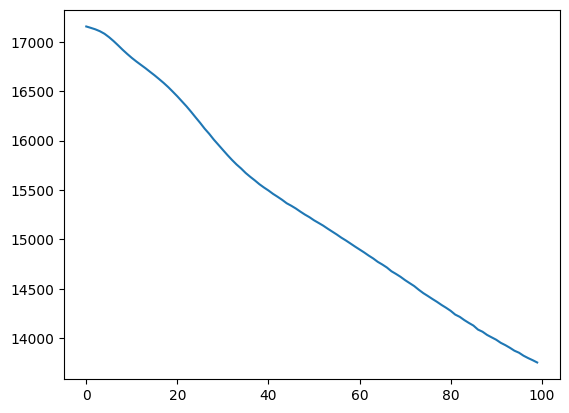

In [10]:
plt.plot(loss_df)

In [11]:
# 6. 예측 수행 및 배치 단위로 MAE 계산
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()
print(y_pred)

tensor([24033.9395, 12635.9902,  5267.2129,  ..., 38755.5820, 36046.8047,
        36109.5508], device='cuda:0')


<Axes: ylabel='Count'>

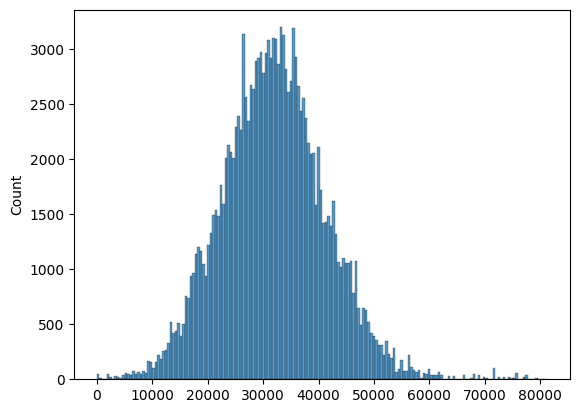

In [14]:
import seaborn as sns
y_pred = y_pred.cpu()
y_pred = pd.Series(y_pred)
sns.histplot(y_pred)

In [15]:
sample_submission["deposit"] = y_pred
sample_submission.to_csv("output.csv", index=False)

In [16]:
y_pred.describe()

count    150172.000000
mean      32006.320312
std        9459.638672
min           0.000000
25%       25756.880371
50%       31822.222656
75%       37779.145508
max       81370.703125
dtype: float64